In [1]:
import cv2
import numpy as np
from skimage import io
from skimage.color import rgb2gray,rgba2rgb
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
from skimage.feature import blob_dog, blob_log, blob_doh, canny
from skimage.morphology import binary_dilation, binary_erosion,binary_opening,binary_closing
from skimage.color import label2rgb
from skimage.measure import label, regionprops
from skimage.morphology import erosion, dilation, opening, closing
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.filters import gaussian
# import pytesseract
# from PIL import Image
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
import easyocr
import tkinter as tk
from PIL import Image, ImageTk
from tkinter.filedialog import askopenfile,askopenfilename



C:\Users\ahmed\AppData\Roaming\Python\Python39\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\ahmed\AppData\Roaming\Python\Python39\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


In [3]:
def isRect(contour):
    (x, y, w, h) = cv2.boundingRect(contour)
    a1 = cv2.contourArea(contour)
    a2 = w*h
    diff = abs(a1-a2)
    return (diff < (0.5 * a2))


In [4]:
def preRatioCheck(width, height, img):
    img_width = img.shape[1]
    img_height = img.shape[0]
    img_area = img_width * img_height
    area = width*height
    min = 0.002*img_area
    max = 0.1*img_area

    ratioMin = 3
    ratioMax = 8

    ratio = float(width) / float(height)

    if (area < min or area > max) or (ratio < ratioMin or ratio > ratioMax):
        return False
    return True


def validateRatio(rect, img):
    (x, y), (width, height), rect_angle = rect
    if rect_angle >= 45:
        (width, height) = (height, width)
    if (height == 0 or width == 0):
        return False
    if not preRatioCheck(width, height, img):
        return False
    else:
        return True

In [5]:
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgBlurred = cv2.GaussianBlur(img, (7, 7), 0)
    sobelx = cv2.Sobel(imgBlurred, cv2.CV_8U, 1, 0, ksize=3)
    ret2, threshold_img = cv2.threshold(
        sobelx, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    element = cv2.getStructuringElement(
        shape=cv2.MORPH_RECT, ksize=(26, 3))
    element2 = cv2.getStructuringElement(
        shape=cv2.MORPH_RECT, ksize=(10, 3))
    morph_n_thresholded_img = threshold_img.copy()
    img_intermediate = morph_n_thresholded_img
    cv2.morphologyEx(src=threshold_img, op=cv2.MORPH_CLOSE,
                     kernel=element, dst=img_intermediate)
    cv2.morphologyEx(src=img_intermediate, op=cv2.MORPH_OPEN,
                     kernel=element2, dst=morph_n_thresholded_img)
    return morph_n_thresholded_img


In [6]:
def fixRange(img):
    max = np.amax(img)
    if(max <= 1):
        return img
    else:
        return img/255


In [7]:
def restoreRange(img):
    max = np.amax(img)
    if(max > 1):
        return img
    else:
        return img*255

In [8]:
def getLicensePlate(processed_img, img):
    contours, _ = cv2.findContours(processed_img, mode=cv2.RETR_EXTERNAL,
                                   method=cv2.CHAIN_APPROX_NONE)
    imgs = []
    for contour in contours:
        min_rect = cv2.minAreaRect(contour)
        if validateRatio(min_rect, img) and isRect(contour):
            x, y, w, h = cv2.boundingRect(contour)
            after_validation_img = img[y:y + h, x:x + w]
            imgs.append(after_validation_img)
    return imgs


In [9]:
def getPlates():
    plates = []
    imagesWithPlates=[]
    for file in os.listdir(os.fsencode("Images")):
        filename = os.fsdecode(file)
        img = io.imread("./Images/" + filename)
        result = []
        processed_img = preprocess(img)
        result += getLicensePlate(processed_img, img)
        plates += result
        for i in range(len(result)):
            imagesWithPlates.append(filename)
    return plates,imagesWithPlates

In [10]:
#test get plates
plates,imagesWithPlates=getPlates()
print(len(plates))

30


In [11]:

def find_end(start,width,black,segmentation_spacing):
    end = start + 1
    black_max = max(black)
    for m in range(start + 1, width - 1):
        if(black[m] > segmentation_spacing * black_max):
            end = m
            break
    return end

In [12]:
def segmentChars(img,segmentation_spacing):

    img = restoreRange(img)
    img = np.array(img, dtype=np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, img_threshold = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

    white = []  # Record the sum of white pixels in each column
    black = []  # Record the sum of black pixels in each column
    height = img_threshold.shape[0]
    width = img_threshold.shape[1]

    for i in range(width):
        white_count = 0
        black_count = 0
        for j in range(height):
            if img_threshold[j][i] == 255:
                white_count += 1
            else:
                black_count += 1

        white.append(white_count)
        black.append(black_count)

    white_max = max(white) 
    n = 1
    chars=[]
    while n < width - 1:
        n += 1
        if(white[n] > (1 - segmentation_spacing) * white_max):
            start = n
            end = find_end(start,width,black,segmentation_spacing)
            n = end
            if end - start > 5:
                character = img[1:height, start:end]
                chars.append(character)      
    return chars                  

8


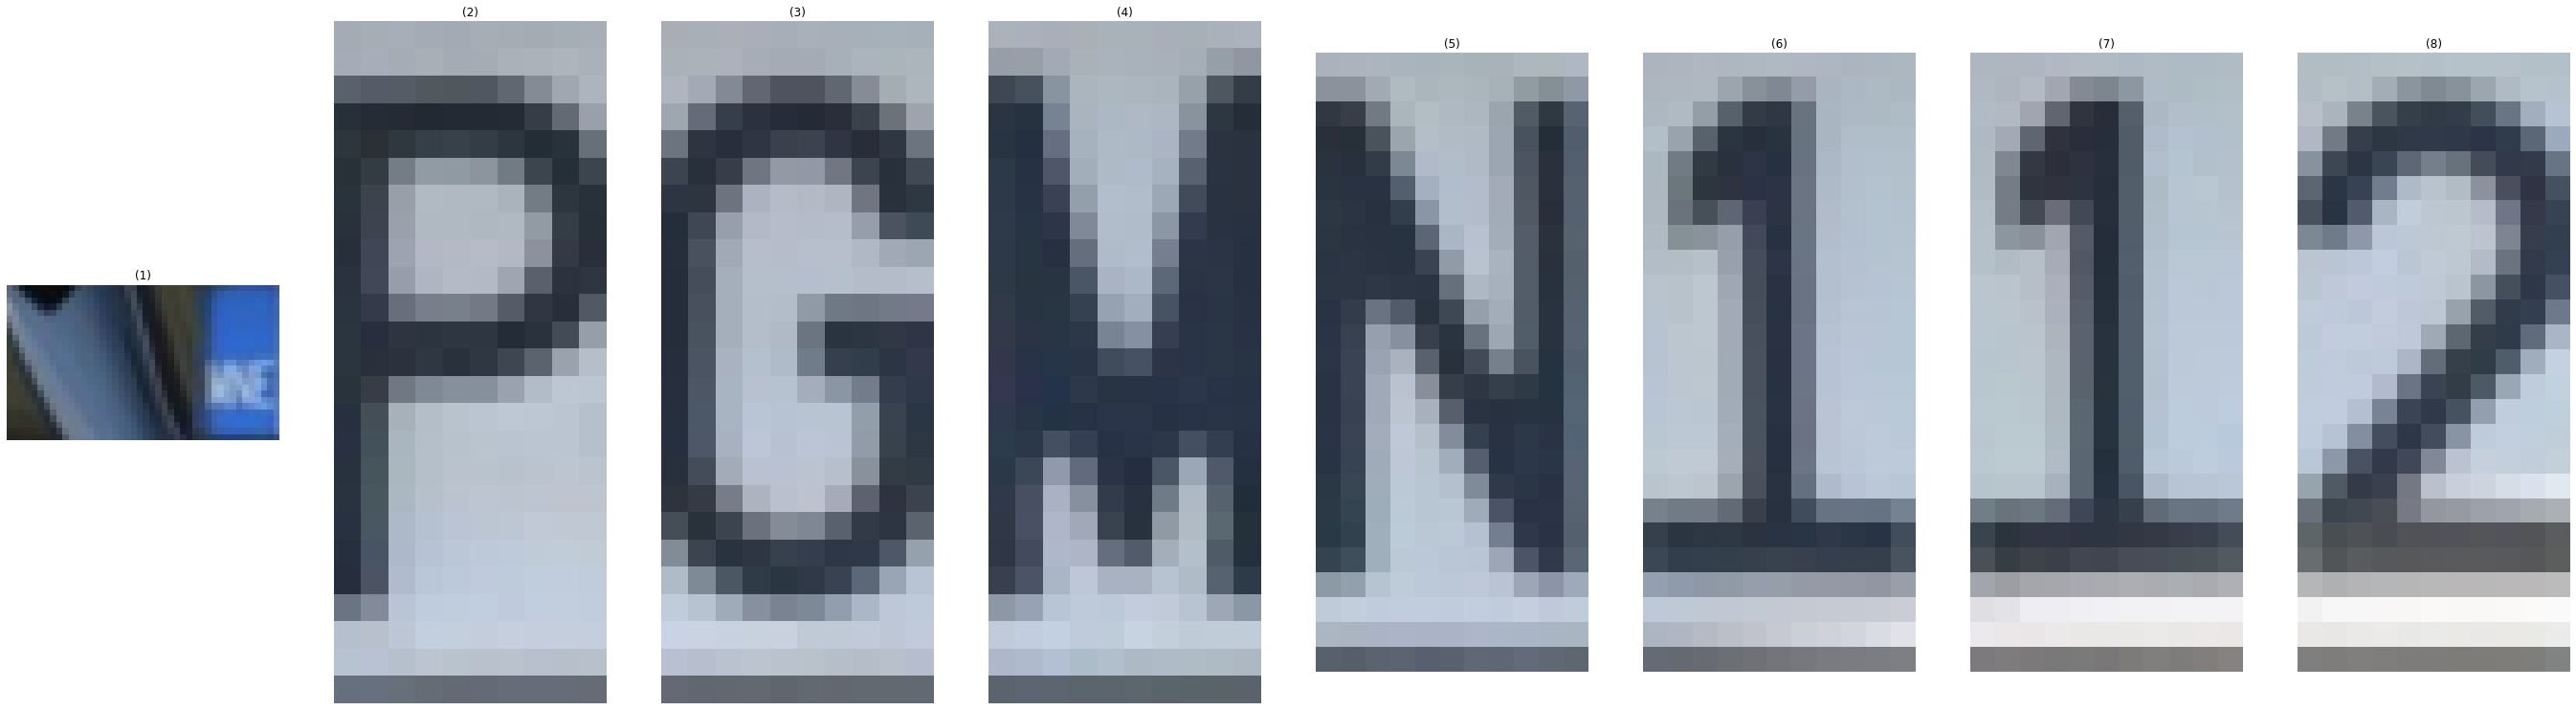

In [13]:
#test segmentation of characters for one of the plate
plates,imagesWithPlates = getPlates()
chars=segmentChars(plates[0],0.93)
print(len(chars))
show_images(chars)

In [14]:
#takes array of images of characters return a string of those characters
def getCharAsString(CharImages):
    reader = easyocr.Reader(['en'])
    length = len(CharImages)
    string = ""
    for i in range(length):
        filename = "{}.jpg".format(os.getpid())
        cv2.imwrite(filename, CharImages[i])
        char=reader.readtext(filename, detail = 0)
        os.remove(filename)
        for i in range(len(char)): 
            string+=char[i]   
    return string        

In [15]:
#This Should not be dileverd it is just for testing
#takes image return text inside
def getTextFromImage(image):
    reader = easyocr.Reader(['en'])
    filename = "{}.jpg".format(os.getpid())
    image=restoreRange(image)
    cv2.imwrite(filename, image)
    string=reader.readtext(filename, detail = 0)
    os.remove(filename)
    return string  

In [16]:
#test getCharAsString 
plates,imagesWithPlates = getPlates()
length=len(plates)
for i in range(length):
    chars=segmentChars(plates[i],0.93)
    string= getCharAsString(chars)
    if  string:
        print("from image {} a licence plate with numbers {} was found".format(imagesWithPlates[i], string))


from image Cars1.png a licence plate with numbers 6 was found
from image Cars11.png a licence plate with numbers 0R56 was found
from image Cars116.png a licence plate with numbers MK-35-32 was found


PermissionError: [WinError 5] Access is denied: '14396.jpg'

In [17]:
#This Should not be dileverd it is just for testing
#test getCharAsString 
plates,imagesWithPlates = getPlates()
length=len(plates)
for i in range(length):
    string= getTextFromImage(plates[i])
    if  string:
        print("from image {} a licence plate with numbers {} was found".format(imagesWithPlates[i], string))

from image Cars1.png a licence plate with numbers ['PGeMN112'] was found
from image Cars11.png a licence plate with numbers ['hor 5i6K'] was found
from image Cars116.png a licence plate with numbers ['IMK-35-32'] was found
from image Cars14.png a licence plate with numbers ['ALR 486'] was found
from image Cars167.png a licence plate with numbers ['15-LK-10898'] was found
from image Cars177.png a licence plate with numbers ['GOOD'] was found
from image Cars34.png a licence plate with numbers ['@L7C N 5617'] was found
from image Cars36.png a licence plate with numbers ['TIDLYPH'] was found
from image Cars53.png a licence plate with numbers ['chio OSE'] was found
from image Cars60.png a licence plate with numbers ['US', '80L:'] was found
from image Cars8.png a licence plate with numbers ['6526 JHD'] was found
from image Cars9.png a licence plate with numbers ['HHO 1478866'] was found
from image image.png a licence plate with numbers ['294.331.85'] was found
from image mcms.jpeg a licence 

In [23]:
def open_file():
    browse_text.set("loading...")
    imgpath = askopenfilename(parent=root, title="Choose an Image", filetypes=[("Images", ".png .jpeg")])
    if imgpath:
        img = io.imread(imgpath)
        plates = []
        processed_img = preprocess(img)
        plates += getLicensePlate(processed_img, img)
        for i in range(len(plates)):
            string= getTextFromImage(plates[i])
            #text box
            if string:
               string="a licence plate with numbers "+ string[0] + " was found \n"
               print(string)
               text_box = tk.Text(root, height=10, width=50, padx=15, pady=15)
               text_box.insert(float(i), string)
               text_box.tag_configure("center", justify="center")
               text_box.tag_add("center", 1.0, "end")
               text_box.grid(column=1, row=3)
        browse_text.set("Browse")

In [24]:
root = tk.Tk()
canvas = tk.Canvas(root, width=600, height=300)
canvas.grid(columnspan=3, rowspan=3)
#logo
logo = Image.open('logo.png')
logo = ImageTk.PhotoImage(logo)
logo_label = tk.Label(image=logo)
logo_label.image = logo
logo_label.grid(column=1, row=0)

#instructions
instructions = tk.Label(root, text="Select an image from your computer", font="Raleway")
instructions.grid(columnspan=3, column=0, row=1)


#browse button
browse_text = tk.StringVar()
browse_btn = tk.Button(root, textvariable=browse_text, command=lambda:open_file(), font="Raleway", bg="#20bebe", fg="white", height=2, width=15)
browse_text.set("Browse")
browse_btn.grid(column=1, row=2)


canvas = tk.Canvas(root, width=600, height=250)
canvas.grid(columnspan=3)

root.mainloop()


a licence plate with numbers 6526 JHD was found 

a licence plate with numbers @L7C N 5617 was found 

